# setup

In [28]:
!pip install category-encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 34.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.


In [56]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from category_encoders import TargetEncoder

import os
import matplotlib.pyplot as plt
import seaborn as sns

my_seed = 59

# data

In [37]:
csvs_folder = '/kaggle/input/cian-big-three/cian_data'
csvs_paths = [os.path.join(csvs_folder, csv) for csv in os.listdir(csvs_folder)]
ds_full = pd.read_csv(csvs_paths[0], delimiter=';')

for csv in csvs_paths[1:]:
    ds_part = pd.read_csv(csv, delimiter=';')
    ds_full = pd.concat([ds_full, ds_part], axis=0, ignore_index=True)

print(len(ds_full))

17107


In [38]:
ds_full.reset_index()
ds_full.head()

,author,author_type,url,location,deal_type,accommodation_type,floor,floors_count,rooms_count,total_meters,price,district,street,house_number,underground,residential_complex
0,Форум-групп,developer,https://ekb.cian.ru/sale/flat/306151208/,Екатеринбург,sale,flat,25,29,5,128.0,34024538.0,Центр,Центральный жилрайон,NaN,Площадь 1905 года,Форма ЖК
1,РЕПУТАЦИЯ,real_estate_agent,https://ekb.cian.ru/sale/flat/304987190/,Екатеринбург,sale,flat,2,10,5,164.0,13300000.0,Орджоникидзевский,переулок Замятина,28,Проспект Космонавтов,NaN
2,PR FLAT,real_estate_agent,https://ekb.cian.ru/sale/flat/315286042/,Екатеринбург,sale,flat,10,10,5,132.6,16100790.0,Центр,Шейнкмана,110,Геологическая,NaN
3,TEN девелопмент,developer,https://ekb.cian.ru/sale/flat/313517303/,Екатеринбург,sale,flat,11,16,5,159.7,69135000.0,Центр,Февральской Революции,21,Динамо,19/05
4,Кулиговская и Партнёры,real_estate_agent,https://ekb.cian.ru/sale/flat/314597466/,Екатеринбург,sale,flat,21,23,5,162.4,64960000.0,Октябрьский,Тверитина,46,Геологическая,NaN


# preprocessing

Основные идеи:
1) избавиться от выбросов;
2) добавление фичи стоимости квадратного метра;
3) target encoding для категориальных признаков;
4) скалирование числовых признаков.

In [39]:
ds_full = ds_full.dropna(axis=0, subset=['price'])
# "location" is important if data contains different cities
redundant_columns = ['author', 'url', 'deal_type', 'accommodation_type']
ds_full = ds_full.drop(redundant_columns, axis=1)
print(len(ds_full))
print(ds_full.describe())

16575
              floor  floors_count   rooms_count  total_meters         price
count  16575.000000  16575.000000  16575.000000  16575.000000  1.657500e+04
mean       7.955053     15.892549      2.624314     87.304992  4.916935e+07
std        7.915672     10.653911      1.310068     60.377137  1.178342e+08
min       -1.000000     -1.000000     -1.000000     10.760000  4.000000e+05
25%        3.000000      8.000000      2.000000     48.000000  9.833106e+06
50%        5.000000     13.000000      3.000000     68.000000  1.520000e+07
75%       11.000000     23.000000      4.000000    104.100000  3.616831e+07
max       82.000000     95.000000      5.000000    979.500000  2.862950e+09


Максимальная и минимальная цены на квартиру:
2862950000.0 400000.0


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


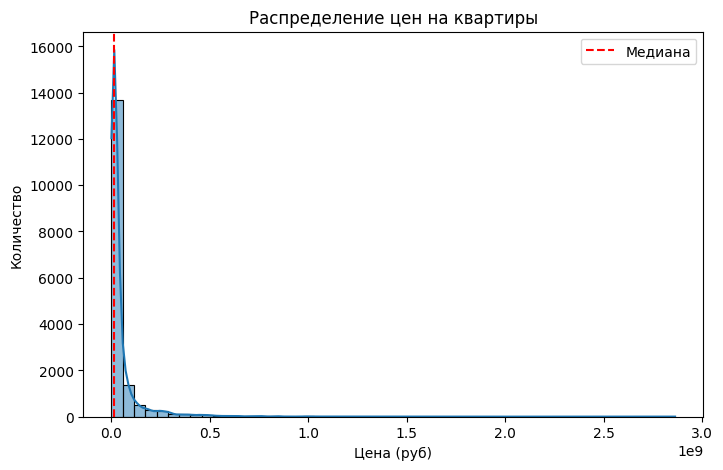

In [40]:
# anomalies in price

print('Максимальная и минимальная цены на квартиру:')
print(max(ds_full['price']), min(ds_full['price']))

plt.figure(figsize=(8, 5))
sns.histplot(ds_full['price'], bins=50, kde=True)
plt.title('Распределение цен на квартиры')
plt.xlabel('Цена (руб)')
plt.ylabel('Количество')
plt.axvline(x=ds_full['price'].median(), color='r', linestyle='--', label='Медиана')
plt.legend()
plt.show();

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


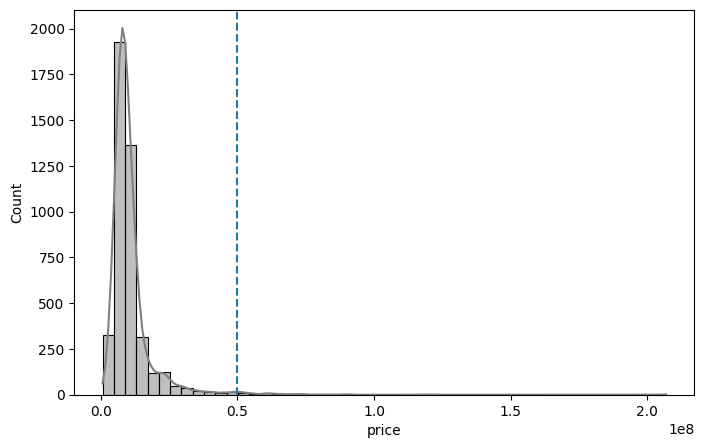

In [41]:
ds_full = ds_full[(ds_full['price'] > 5e5) & (ds_full['price'] < 5e8)]

plt.figure(figsize=(8, 5))
sns.histplot(ds_full[ds_full['location'] == 'Екатеринбург']['price'], bins=50, kde=True, color='gray')
plt.axvline(x=ds_full[ds_full['location'] == 'Екатеринбург']['price'].quantile(0.99), linestyle='dashed')
plt.show();

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


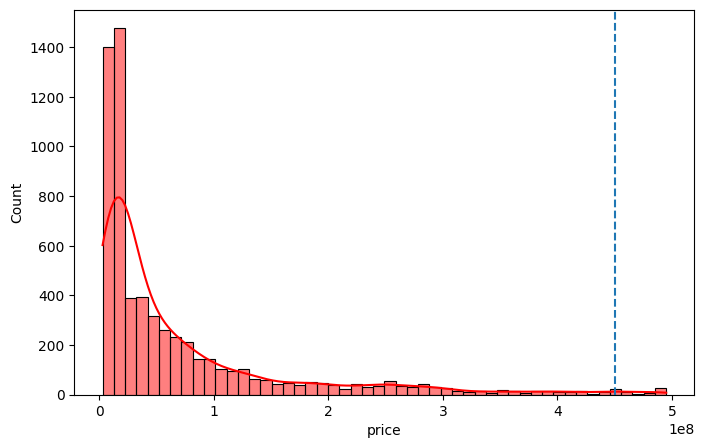

In [42]:
plt.figure(figsize=(8, 5))
sns.histplot(ds_full[ds_full['location'] == 'Москва']['price'], bins=50, kde=True, color='red')
plt.axvline(x=ds_full[ds_full['location'] == 'Москва']['price'].quantile(0.99), linestyle='dashed')
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


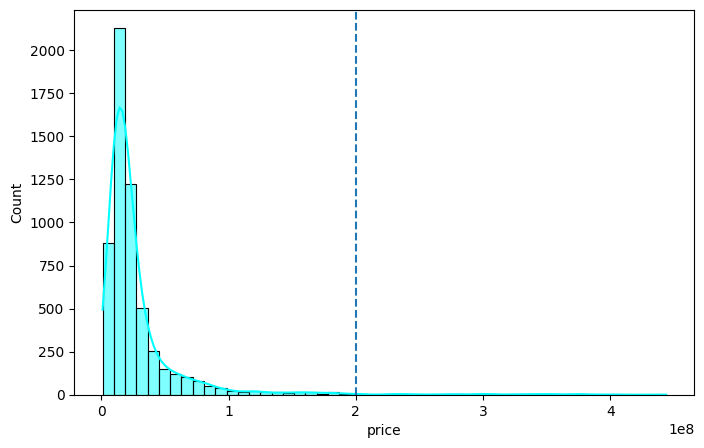

In [43]:
plt.figure(figsize=(8, 5))
sns.histplot(ds_full[ds_full['location'] == 'Санкт-Петербург']['price'], bins=50, kde=True, color='cyan')
plt.axvline(x=ds_full[ds_full['location'] == 'Санкт-Петербург']['price'].quantile(0.99), linestyle='dashed')
plt.show()

In [44]:
# для каждого города выкидываем то, что ниже 0.01 и выше 0.99 перцентилей

for city in ds_full['location'].unique():
    low = ds_full[ds_full['location'] == city]['price'].quantile(0.01)
    high = ds_full[ds_full['location'] == city]['price'].quantile(0.99)
    anomalies = ds_full[(ds_full['location'] == city) & ((ds_full['price'] < low) | (ds_full['price'] > high))].index
    print(f'{len(anomalies)} anomalies for {city} city')
    ds_full.drop(anomalies, inplace=True)

print(len(ds_full))

88 anomalies for Екатеринбург city
115 anomalies for Санкт-Петербург city
114 anomalies for Москва city
16065


In [45]:
# drop rooms_count == -1
ds_full = ds_full[ds_full['rooms_count'] > 0]
print(len(ds_full))

16050


In [46]:
# фича квадратных метров
ds_full['price_per_m2'] = ds_full['price'] / ds_full['total_meters']

In [47]:
# fix NaN in cat. features
object_cols = [col for col in ds_full.columns if ds_full[col].dtype == "object"]
for col in object_cols:
    ds_full[col] = ds_full[col].fillna('unknown')
    ds_full[col] = ds_full[col].str.strip().str.lower()

In [48]:
X, y = ds_full.drop(['price'], axis=1), ds_full['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=my_seed)
print(len(X_train), len(X_test), len(y_train), len(y_test))

12840 3210 12840 3210


In [49]:
object_cols = [col for col in X_train.columns if X_train[col].dtype == "object"]
object_nunique = list(map(lambda col: X_train[col].nunique(), object_cols))
d = dict(zip(object_cols, object_nunique))

# high cardinality in some columns
sorted(d.items(), key=lambda x: x[1])

[('location', 3),
 ('author_type', 7),
 ('district', 177),
 ('underground', 371),
 ('residential_complex', 1271),
 ('house_number', 1346),
 ('street', 1869)]

In [50]:
# target encoding for high cardinality
low_cardinality_cols = [col for col in object_cols if X_train[col].nunique() < 20]
print(low_cardinality_cols)
high_cardinality_cols = list(set(object_cols)-set(low_cardinality_cols))
print(high_cardinality_cols)

encoder = TargetEncoder(cols=high_cardinality_cols, smoothing=10.0)

X_train_encoded = encoder.fit_transform(X_train[high_cardinality_cols], y_train)
X_test_encoded = encoder.transform(X_test[high_cardinality_cols])

X_train = pd.concat([X_train.drop(high_cardinality_cols, axis=1), X_train_encoded], axis=1)
X_test = pd.concat([X_test.drop(high_cardinality_cols, axis=1), X_test_encoded], axis=1)

['author_type', 'location']
['district', 'house_number', 'underground', 'street', 'residential_complex']


In [57]:
# scaling all numeric cols, including target encoded

numeric_cols = [col for col in X_train.columns if (X_train[col].dtype in ['int64', 'float64', 'int32', 'float32'])]
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [58]:
# ohe encoding for low cardinality

ohe_encoding = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
for col in low_cardinality_cols:
    ohe_cats_array = ohe_encoding.fit_transform(X_train[[col]])
    ohe_cats_df = pd.DataFrame(ohe_cats_array, 
                               columns=[f"{col}_{cat}" for cat in ohe_encoding.categories_[0]],
                               index=X_train.index)
    X_train = pd.concat([X_train, ohe_cats_df], axis=1).drop([col], axis=1)

    ohe_test_cats_array = ohe_encoding.transform(X_test[[col]])
    ohe_test_cats_df = pd.DataFrame(ohe_test_cats_array, 
                                    columns=[f"{col}_{cat}" for cat in ohe_encoding.categories_[0]],
                                    index=X_test.index)
    
    X_test = pd.concat([X_test, ohe_test_cats_df], axis=1).drop([col], axis=1)

X_train.head()

,floor,floors_count,rooms_count,total_meters,price_per_m2,district,house_number,underground,street,residential_complex,author_type_developer,author_type_homeowner,author_type_official_representative,author_type_real_estate_agent,author_type_realtor,author_type_representative_developer,author_type_unknown,location_екатеринбург,location_москва,location_санкт-петербург
4503,6.374989,6.395300,-0.479292,-0.059601,1.305950,2.428251,1.706521,3.113370,1.827127,1.382547,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
11808,-0.126717,-0.664920,0.303574,0.355532,0.060675,0.524058,-0.281267,-0.383263,0.480514,0.144895,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
7967,-0.751882,-0.943613,1.869307,1.268061,0.442575,2.245745,4.597077,0.918480,0.357400,-0.026950,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
13552,0.248381,0.821442,-1.262158,-0.803780,-0.621971,-0.534690,-0.895007,-0.383263,-0.540402,-0.097657,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6040,-0.751882,-0.014636,-0.479292,-0.578040,0.177302,-0.387247,-0.303331,-0.179895,0.000825,0.048021,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [59]:
# old frequency encoding
# maybe normalize in .value_counts()?..
# for col in high_cardinality_cols:
#     freq_map = X_train[col].value_counts(normalize=True).to_dict()
    
#     X_train[col+'_freqs'] = X_train[col].map(freq_map)
#     X_train = X_train.drop(col, axis=1)

#     X_test[col+'_freqs'] = X_test[col].map(freq_map)
#     X_test = X_test.drop(col, axis=1)

In [61]:
X_train.to_pickle('x_train.pkl') 
y_train.to_pickle('y_train.pkl') 
X_test.to_pickle('x_test.pkl') 
y_test.to_pickle('y_test.pkl') 

In [62]:
print(X_train.columns)
X_train.head()

Index(['floor', 'floors_count', 'rooms_count', 'total_meters', 'price_per_m2',
       'district', 'house_number', 'underground', 'street',
       'residential_complex', 'author_type_developer', 'author_type_homeowner',
       'author_type_official_representative', 'author_type_real_estate_agent',
       'author_type_realtor', 'author_type_representative_developer',
       'author_type_unknown', 'location_екатеринбург', 'location_москва',
       'location_санкт-петербург'],
      dtype='object')


,floor,floors_count,rooms_count,total_meters,price_per_m2,district,house_number,underground,street,residential_complex,author_type_developer,author_type_homeowner,author_type_official_representative,author_type_real_estate_agent,author_type_realtor,author_type_representative_developer,author_type_unknown,location_екатеринбург,location_москва,location_санкт-петербург
4503,6.374989,6.395300,-0.479292,-0.059601,1.305950,2.428251,1.706521,3.113370,1.827127,1.382547,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
11808,-0.126717,-0.664920,0.303574,0.355532,0.060675,0.524058,-0.281267,-0.383263,0.480514,0.144895,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
7967,-0.751882,-0.943613,1.869307,1.268061,0.442575,2.245745,4.597077,0.918480,0.357400,-0.026950,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
13552,0.248381,0.821442,-1.262158,-0.803780,-0.621971,-0.534690,-0.895007,-0.383263,-0.540402,-0.097657,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6040,-0.751882,-0.014636,-0.479292,-0.578040,0.177302,-0.387247,-0.303331,-0.179895,0.000825,0.048021,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
